# forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import pickle

In [45]:
# Read the data set from csv file
train = pd.read_csv('train.csv')

In [46]:
# Let’s have a glimpse of the raw data.
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1/1/2011 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1/1/2011 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1/1/2011 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1/1/2011 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [47]:
# Get the size of samples and number of feature
print("shape:", train.shape)

# some info about the data like data type
print(train.info())

shape: (10886, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


In [48]:
# Split the datatime feature to mini-feature
def rebuild_datetime(frame):
    dt = pd.DatetimeIndex(frame['datetime'])
    frame['date'] = dt.date
    frame['month'] = dt.month
    frame['hour'] = dt.hour

    # Dropping unncessary columns : datetime column
    frame.drop('datetime', axis=1, inplace=True)
rebuild_datetime(train)

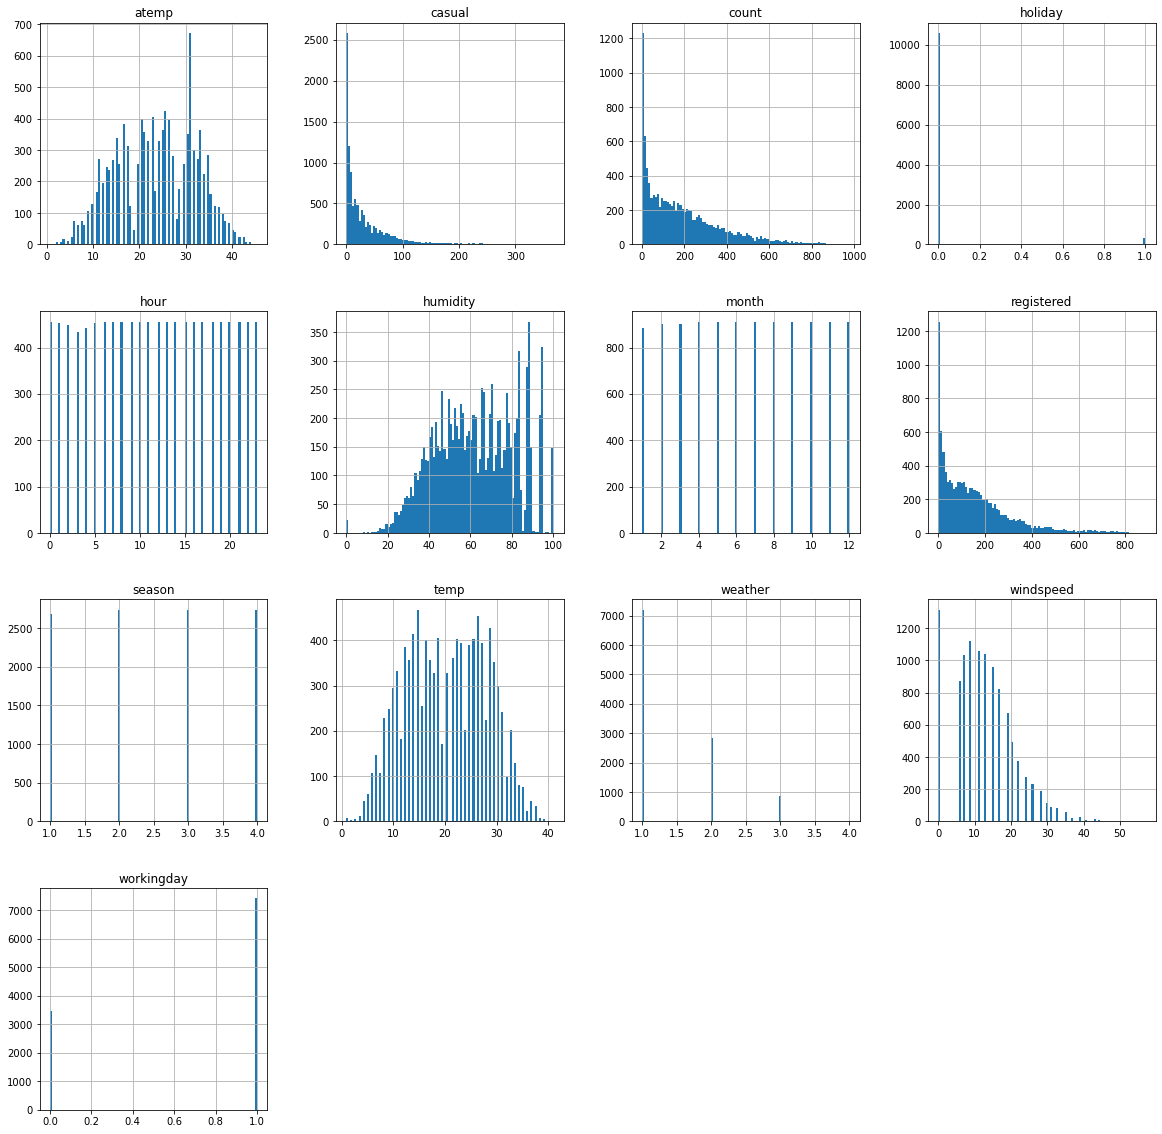

In [49]:
# Show feature as fig
train.hist(bins=100, figsize=(20,20))
plt.show()

In [50]:
# Drop constant feature
# and the Holiday only account for a less than 3% of total poluation,
#  so this feature is not good feature to select.
def drop_constant(frame, constant):
    for con in constant:
        if(con in frame.columns.values) :
            frame.drop(columns=[con], axis=1, inplace=True)
            
constant_feature = "holiday", "date", "workingday"
drop_constant(train, constant_feature)

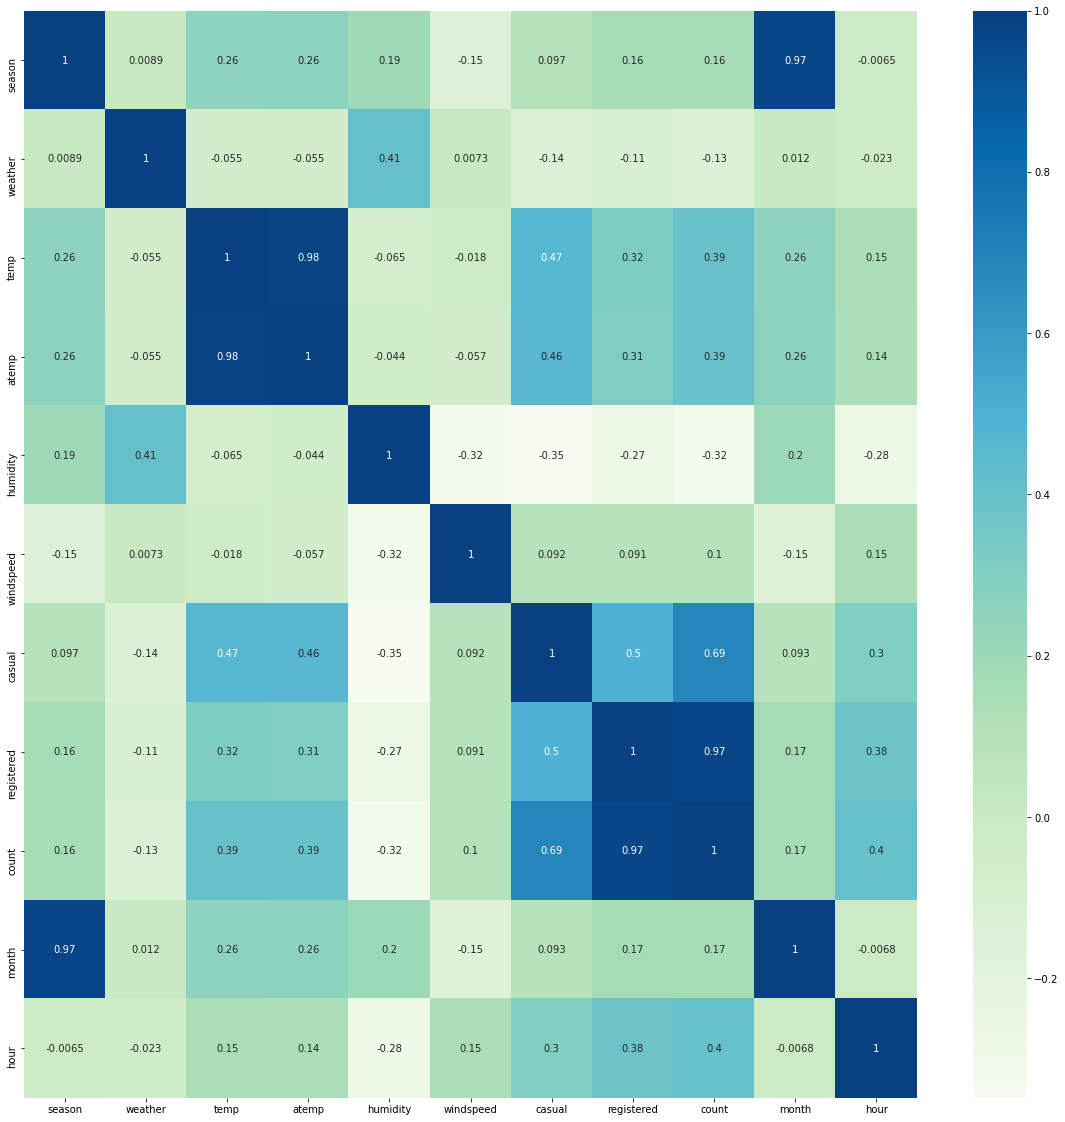

In [51]:
# Show correlation between each feature
plt.figure(figsize=(20,20))
correlation = train.corr()
sns.heatmap(correlation, cmap="GnBu", annot = True)

In [52]:
# Following pairs has highly correlated features (>=60%):
## season & month (0.97)
## temp & atemp (0.98)
## casual & count (0.69)
## registered & count (0.97)
# Based on this result, I dropped variables which
#  has highly correlated with features:
def drop_high_corr(frame, correlated):
    for corr in correlated:
        if(corr in frame.columns.values) :
            frame.drop(columns=[corr], axis=1, inplace=True)
    return frame
correlated_feature = "season","casual","registered", "atemp"
train = drop_high_corr(train,correlated_feature)

In [53]:
# Handel outleir by target feaature
def handle_outleir(frame, target):
    frame = frame[np.abs(frame[target]-frame[target].mean())<=(3*frame[target].std())]

handle_outleir(train, "count")

In [54]:
# Split the features from target feature
y = np.array(train['count'])
x = train.drop('count', axis=1)
y = y.reshape((len(y),1))

standard_scaler = StandardScaler()
y_trans = standard_scaler.fit_transform(y)
x_trans = standard_scaler.fit_transform(x)

# Split sets into training and test dataset : 70% for training 
x_train, x_test, y_train ,y_test = train_test_split(x_trans, y_trans, random_state = 42, test_size=0.30)

#  create some polynomial features before creating a linear regression

In [88]:
# Generate polynomial features
# degree by default =2
poly = PolynomialFeatures()

# Fit to data, then transform it.
# and returns a transformed version of X.
poly_x_train = poly.fit_transform(x_train)
poly_x_test = poly.fit_transform(x_test)

# Create linear regression object then Train the model using the training sets
lr = LinearRegression()
lr.fit(poly_x_train, y_train)

# Make predictions using the polynomial set
pridiction_test = lr.predict(poly_x_test)

# get the coefficients of the model
lr.coef_

# ge the intercept value
lr.intercept_

# The mean squared error
print('Mean squared error:', mean_squared_error(y_test, pridiction_test))

Mean squared error: 0.5224834425516091


## Save the model object into files

In [56]:
pickle.dump(lr, open('./model.sav', 'wb'))